                           Escola Politécnica da Universidade de São Paulo
                                         Data: 13/09/2019
#       PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões
### Análise e aplicação do k-NN a base *adult*
#### Autor: Lucas Nunes Sequeira

## 1. Preparação dos dados (*Data Prep*)

Nessa primeira etapa, começo importando algumas bibliotecas que usaremos ao longo do desenvolvimento do notebook. Além disso, faremos um tratamento nos **dados faltantes** com o uso da biblioteca *pandas*.

### 1.1 Importação de bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

### 1.2 Importação dos dados

Agora, subo o arquivo *train_data.csv* através do *pandas* na forma de **DataFrame**, considerando também valores <font color='red'>*?*</font> como <font color='red'>*Nan*</font>.

In [2]:
df_train = pd.read_csv('train_data.csv', na_values = '?')
df_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [3]:
print('Forma do DataFrame:', df_train.shape)

Forma do DataFrame: (32560, 16)


### 1.3 Identificando os **dados faltantes** (*missing data*)

Nessa etapa dessa seção, identifico os **dados faltantes** utilizando algumas ferramentas do *pandas*. Para em seguida analisar o tipo, se é aleatório ou não por exemplo.

In [4]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = ((df_train.isnull().sum()/df_train.isnull().count())*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', '%'])
missing_data.head()

,Total,%
occupation,1843,5.660319
workclass,1836,5.638821
native.country,583,1.790541
income,0,0.000000
hours.per.week,0,0.000000


Podemos observar que os **dados faltantes** concentram-se em 3 colunas: '*occupation*', '*workclass*' e '*native.country*'. Observo as distribuições das colunas, para analisarmos melhor:

In [5]:
print('occupation:\n')
print(df_train['occupation'].describe())

print('\n\nworkclass:\n')
print(df_train['workclass'].describe())

print('\n\nnative.country:\n')
print(df_train['native.country'].describe())

occupation:

count              30717
unique                14
top       Prof-specialty
freq                4140
Name: occupation, dtype: object


workclass:

count       30724
unique          8
top       Private
freq        22696
Name: workclass, dtype: object


native.country:

count             31977
unique               41
top       United-States
freq              29169
Name: native.country, dtype: object


Para os três casos, devido a alta frequência da moda, utilizarei a moda como valor imputado.

In [6]:
value = df_train['workclass'].describe().top
df_train['workclass'] = df_train['workclass'].fillna(value)

value = df_train['native.country'].describe().top
df_train['native.country'] = df_train['native.country'].fillna(value)

value = df_train['occupation'].describe().top
df_train['occupation'] = df_train['occupation'].fillna(value)

In [7]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = ((df_train.isnull().sum()/df_train.isnull().count())*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', '%'])
missing_data.head()

,Total,%
income,0,0.0
native.country,0,0.0
hours.per.week,0,0.0
capital.loss,0,0.0
capital.gain,0,0.0


Como podemos observar, agora nosso banco de dados para o treino está limpo e pronto para ser analisado.

## 2. Análise exploratória dos dados

Nessa etapa, utilizarei as bibliotecas: *matplotlib*, *pandas* e *seaborn* como ferramentas para analisarmos e visualizarmos os dados, e assim tirar algumas conclusões sobre os mesmos.

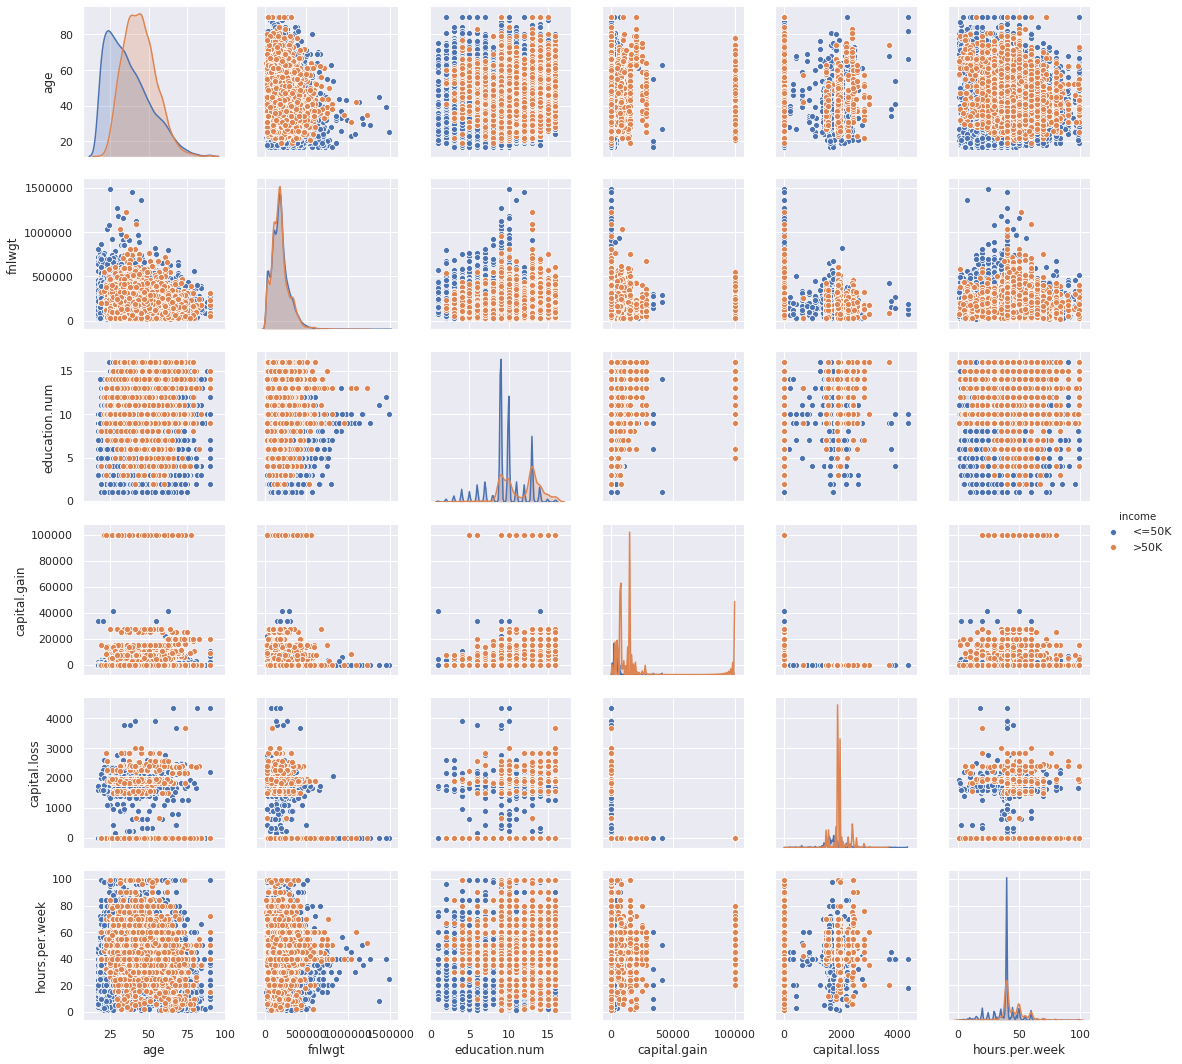

In [8]:
cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
sns.set()
sns.pairplot(df_train, vars = cols, hue = 'income')

### 2.1 Descrição dos dados

Observaremos com o uso da função *.describe()* e *.hist()* do *pandas* para clarear nossas primeiras inferências.

In [9]:
df_train.describe()

,Id,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


De cara observamos que as colunas *capital.gain* e *capital.loss* possuem grupos bem definidos e distantes, para isso, veremos seu histograma:

Text(0.5, 1.0, 'Capital gain histogram')

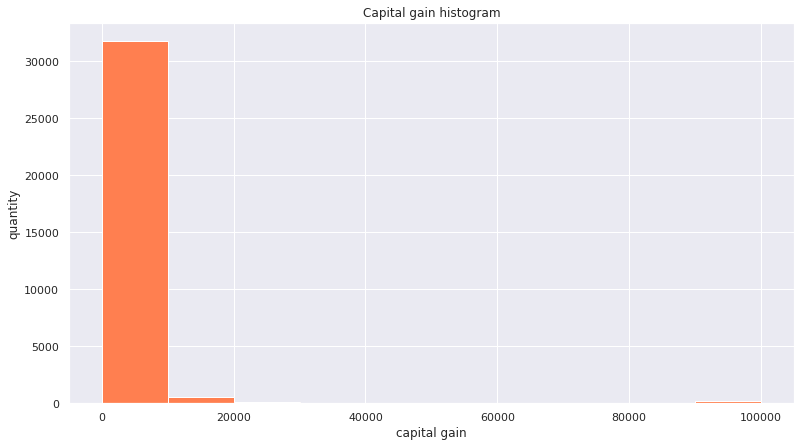

In [10]:
plt.figure(figsize=(13, 7))
df_train['capital.gain'].hist(color = 'coral')
plt.xlabel('capital gain')
plt.ylabel('quantity')
plt.title('Capital gain histogram')

Text(0.5, 1.0, 'Capital loss histogram')

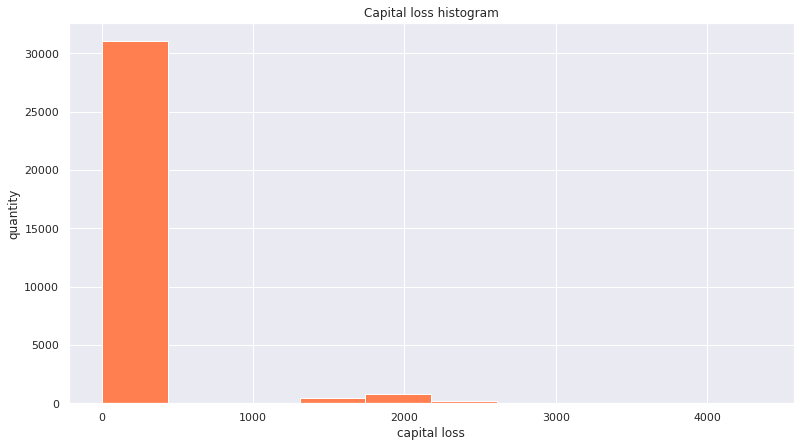

In [11]:
plt.figure(figsize=(13, 7))
df_train['capital.loss'].hist(color = 'coral')
plt.xlabel('capital loss')
plt.ylabel('quantity')
plt.title('Capital loss histogram')

Logo vemos que há uma concentração quase absoluta para valores pequenos, enquanto há poucos, bastante altos. Agora para termos uma noção da curva de idades do banco de dados, avalio com *.hist()*

Text(0.5, 1.0, 'Age histogram')

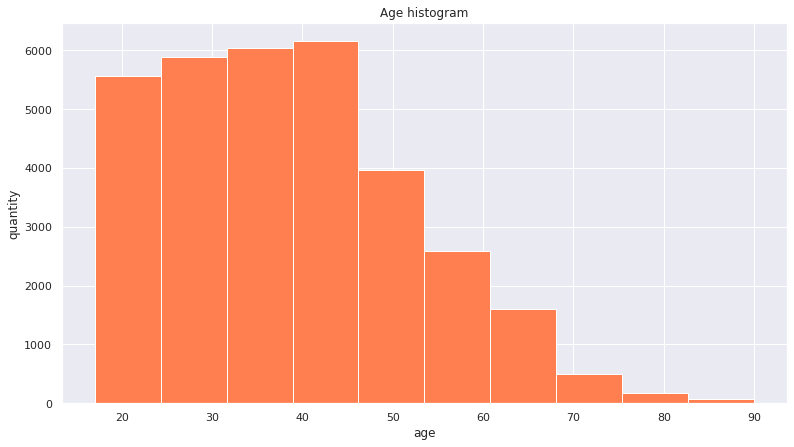

In [12]:
plt.figure(figsize=(13, 7))
df_train['age'].hist(color = 'coral')
plt.xlabel('age')
plt.ylabel('quantity')
plt.title('Age histogram')

Além disso, podemos também avaliar com a função *.distplot()* do *seaborn* para compararmos com uma **curva de distribuição**.

Text(0.5, 1.0, 'Distribution of age')

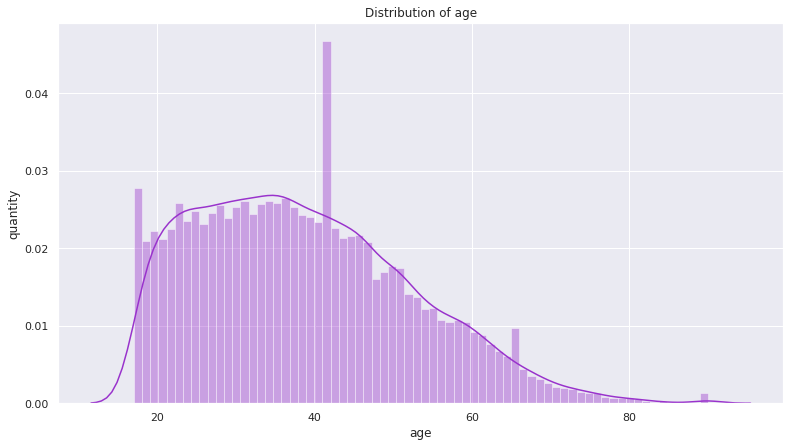

In [13]:
sns.set()
plt.figure(figsize=(13,7))
sns.distplot(df_train['age'], color = 'darkorchid', bins = 70)
plt.ylabel('quantity')
plt.title('Distribution of age')

Vemos que há uma grande quantidade de jovens (20 a 40 anos) nessa população.

Text(0.5, 1.0, 'Hours per week histogram')

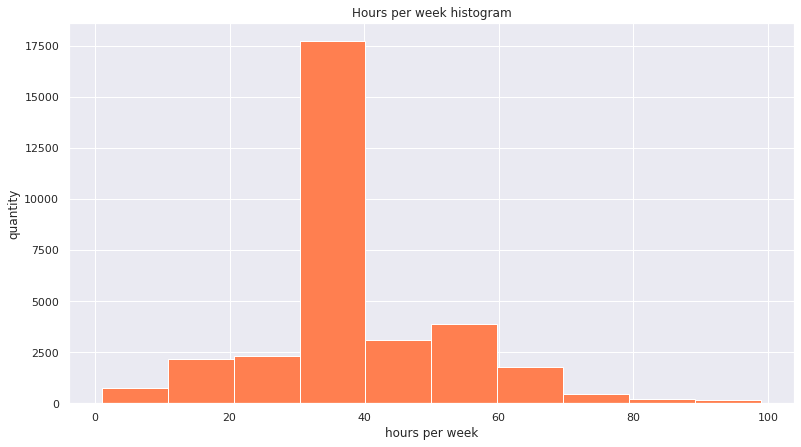

In [14]:
plt.figure(figsize=(13, 7))
df_train['hours.per.week'].hist(color = 'coral')
plt.xlabel('hours per week')
plt.ylabel('quantity')
plt.title('Hours per week histogram')

Concluímos também que em maioria (e em média) os indivídos desse banco de dados trabalham 40 horas por semana (8 horas por dia e finais de semana livre) o que é saudável. No entanto, há uma parcela significativa que excede esse número, analiso a seguir.

Text(0.5, 1.0, 'Hours per week histogram')

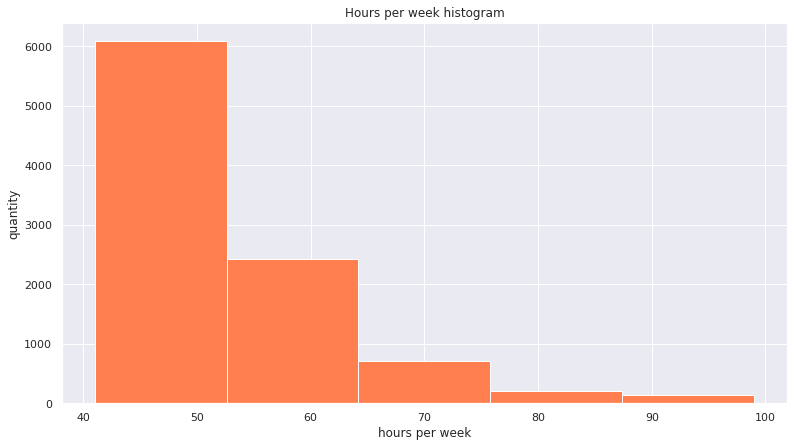

In [15]:
super_work = df_train[df_train['hours.per.week'] > 40]
plt.figure(figsize=(13, 7))
super_work['hours.per.week'].hist(color = 'coral', bins = 5)
plt.xlabel('hours per week')
plt.ylabel('quantity')
plt.title('Hours per week histogram')

E esses '*super trabalhadores*' que trabalham acima de 40 horas por semana constituem um grupo que cai exponencialmente com as horas de trabalho, no entanto, vemos por exemplo que em média eles trabalham:

In [16]:
mean = super_work['hours.per.week'].describe()['mean']
print('{0} horas por semana ({1} horas por dia com finais de semana livre). O que é algo que já começa a ser bastante desgastante para o trabalhador.'.format(int(mean), int(mean/5)))

53 horas por semana (10 horas por dia com finais de semana livre). O que é algo que já começa a ser bastante desgastante para o trabalhador.


### 2.2 Comparação dos dados

Nessa subseção faremos uma análise comparativa entre os dados dos indivídos do banco de dados. Utilizaremos histogramas, gráficos de pizza e boxplots.

Primeiro, crio uma função de comparação para histogramas.

In [17]:
def compare_histogram(df, obj_var, test_var, obj_labels = None, alpha = 0.7):
    
    if obj_labels is None:
        obj_labels = df[obj_var].unique()
    
    #obj_var = 'income'
    #obj_labels = ['>50K', '<=50K']
    #test_var = 'age' (for example)
    
    temp = []
    n_labels = len(obj_labels)
    for i in range(n_labels):
        temp.append(df[df[obj_var] == obj_labels[i]])
        temp[i] = np.array(temp[i][test_var]).reshape(-1,1)

    fig = plt.figure(figsize= (13,7))
    
    for i in range(n_labels):
        plt.hist(temp[i], alpha = alpha)
    plt.xlabel(test_var)
    plt.ylabel('quantity')
    plt.title('Histogram over \'' + test_var + '\' filtered by \'' + obj_var + '\'')
    plt.legend(obj_labels)

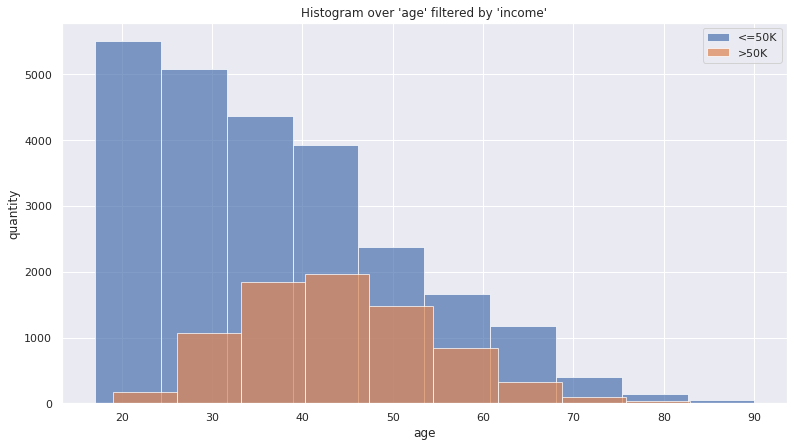

In [18]:
compare_histogram(df_train, 'income', 'age')

Sobre o histograma acima (*age* e *income*) vemos que há uma distribuição relativamente normal sobre as pessoas que recebem *>50K* com o termo médio próximo de 45 anos; já para pessoas *<=50K* , observa-se que com o aumento da idade, há uma redução na quantidade de pessoas que recebem o valor.

Agora, farei uma análise sobre a distribuição de sexo.

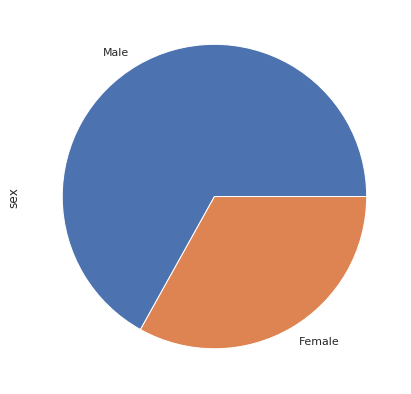

In [19]:
plt.figure(figsize=(13, 7))
df_train['sex'].value_counts().plot(kind = 'pie')

Vemos que há nos dados, mais homens que mulheres, com relação à esses valores, temos:

In [20]:
# male = qtd sex == Male
male = df_train[df_train['sex'] == 'Male'].count()[0]

# female = qtd sex == Female
female = df_train.shape[0] - male

In [21]:
print("Temos {0} homens e {1} mulheres, ou seja, apenas {2:3.2f}% são mulheres.".format(male, female, female*100/(female+male)))

Temos 21789 homens e 10771 mulheres, ou seja, apenas 33.08% são mulheres.


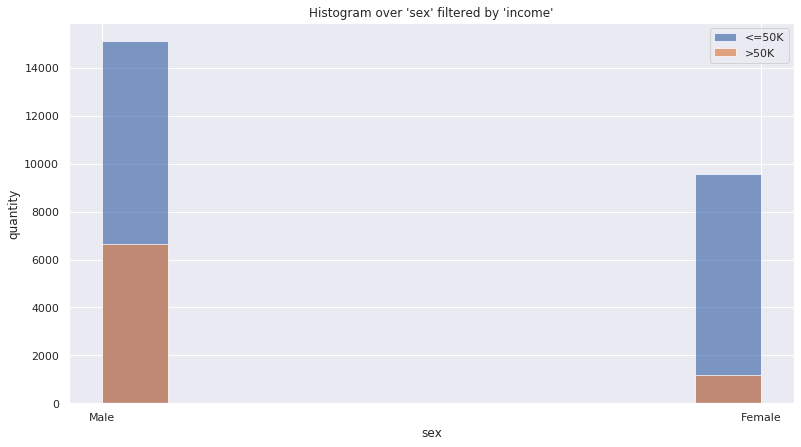

In [22]:
compare_histogram(df_train, 'income', 'sex')

Sobre o histograma acima, nota-se que há uma grande discrepância percentual (veja os valores abaixo) entre mulheres que recebem *>50K* e homens que recebem o mesmo valor, vemos que há muito mais homens que recebem *>50K*. Esses resultados sugerem que há **desigualdade de gênero** tratando-se do salário.

In [23]:
# male_income = [qtd > 50K, qtd <= 50K]
male_income = []
temp = df_train[df_train['sex'] == 'Male']
male_income.append(temp[temp['income'] == '>50K'].count()[0])
male_income.append(male-male_income[0])

# female_income = [qtd > 50K, qtd <= 50K]
female_income = []
temp = df_train[df_train['sex'] == 'Female']
female_income.append(temp[temp['income'] == '>50K'].count()[0])
female_income.append(female-female_income[0])

# % of male that has >50K income:
male_over = male_income[0]/male

# % of female that has >50K income:
female_over = female_income[0]/female

In [24]:
print('Temos que dentre os homens, {0:1.2f}% possuem renda anual superior a 50.000, já dentre as mulheres, temos {1:2.2f}% apenas que possuem renda anual superior a 50.000.'.format(male_over*100, female_over*100))

Temos que dentre os homens, 30.58% possuem renda anual superior a 50.000, já dentre as mulheres, temos 10.95% apenas que possuem renda anual superior a 50.000.


Ainda sobre a questão de gênero, temos:

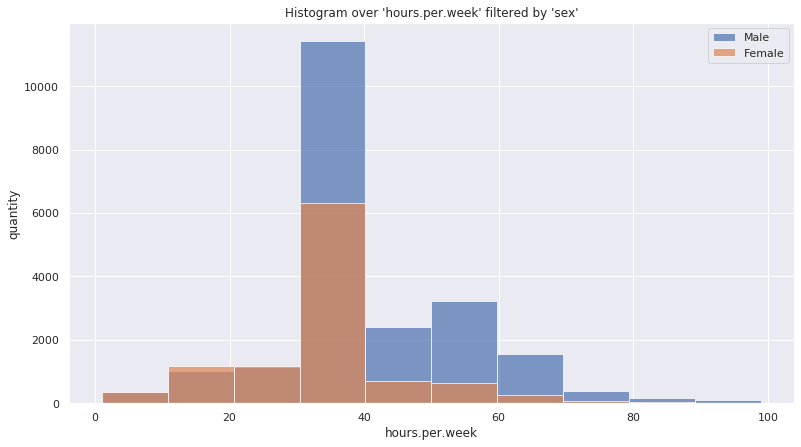

In [25]:
compare_histogram(df_train, 'sex', 'hours.per.week')

O que vemos é que existem muito mais homens (inclusive percentualmente) que trabalham mais de 40 horas por semana, e percentualmente vemos mais mulheres trabalhando menos de 30 horas semanais. Agora analisarei as ocupações.

In [26]:
female = df_train[df_train['sex'] == 'Female']
male = df_train[df_train['sex'] == 'Male']

Text(0.5, 1.0, 'Histogram of female over occupations')

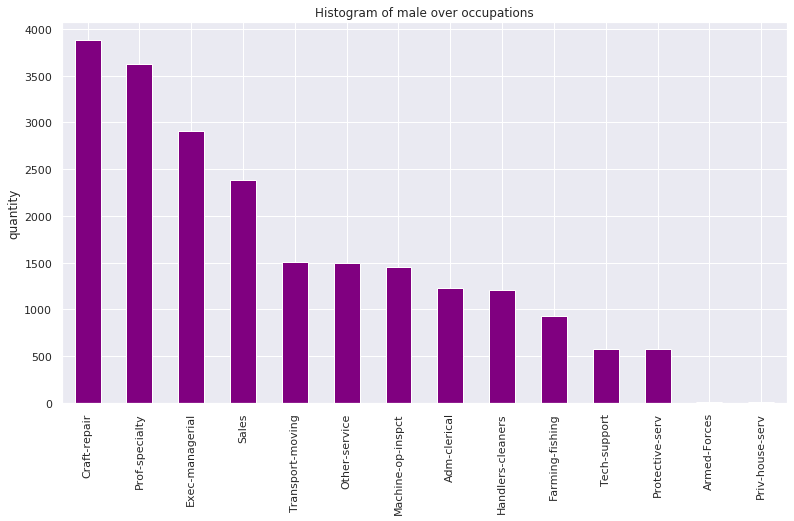

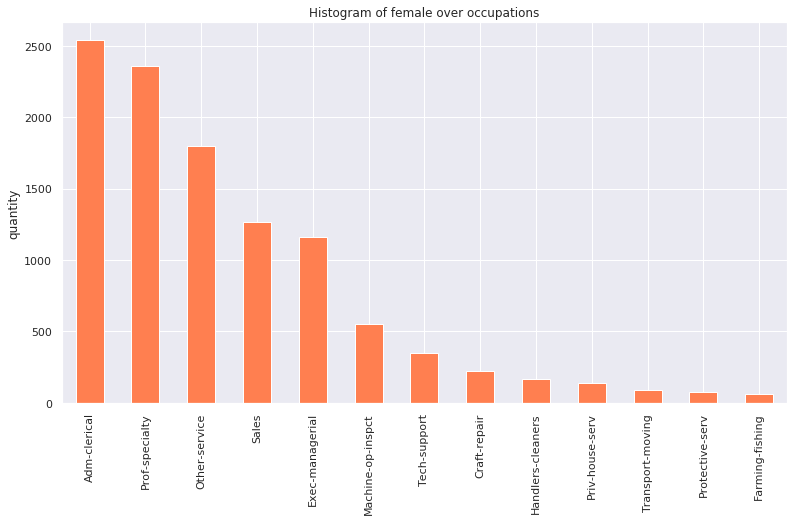

In [27]:
plt.figure(figsize=(13, 7))
male['occupation'].value_counts().plot(kind = 'bar', color = 'purple')
plt.ylabel('quantity')
plt.title('Histogram of male over occupations')

plt.figure(figsize=(13, 7))
female['occupation'].value_counts().plot(kind = 'bar', color = 'coral')
plt.ylabel('quantity')
plt.title('Histogram of female over occupations')

Observamos que há uma nítida diferença entre a empregabilidade dos homens e das mulheres. Além disso observamos também que não há mulheres que trabalham nas *Armed-Forces*, será uma política exclusiva?

Agora, faremos algumas análises étnicas.

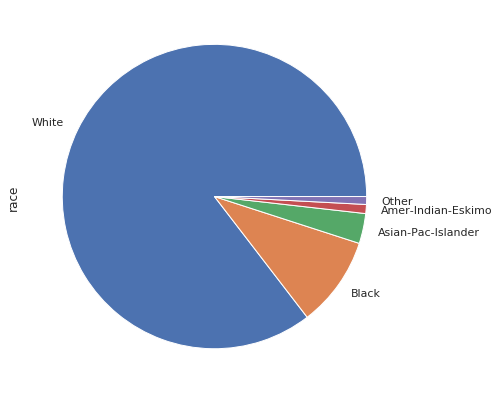

In [28]:
plt.figure(figsize=(13, 7))
df_train['race'].value_counts().plot(kind = 'pie')

O que vemos é uma concentração bastante elevada da quantidade de pessoas brancas nessa população pesquisada.

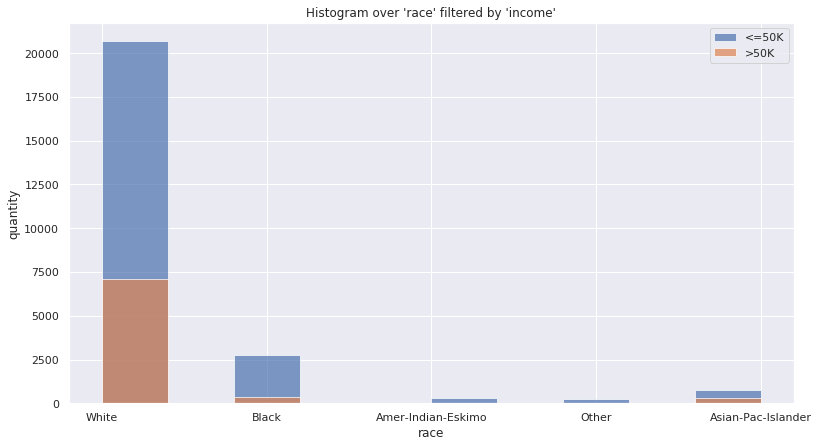

In [29]:
compare_histogram(df_train, 'income', 'race')

Observando o histograma acima, podemos de cara visualizar que provavelmente há um percentual maior de pessoas brancas que recebem mais do 50.000 sobre as pessoas negras, amer-indian-eskimo e outros. Os valores seguem abaixo.

In [30]:
# kind = qtd race == 'unique'
white = df_train[df_train['race'] == 'White'].count()[0]
black = df_train[df_train['race'] == 'Black'].count()[0]
amer = df_train[df_train['race'] == 'Amer-Indian-Eskimo'].count()[0]
other = df_train[df_train['race'] == 'Other'].count()[0]
asian = df_train[df_train['race'] == 'Asian-Pac-Islander'].count()[0]

# kind_income = [qtd > 50K, qtd <= 50K]
white_income = []
temp = df_train[df_train['race'] == 'White']
white_income.append(temp[temp['income'] == '>50K'].count()[0])
white_income.append(white-white_income[0])

black_income = []
temp = df_train[df_train['race'] == 'Black']
black_income.append(temp[temp['income'] == '>50K'].count()[0])
black_income.append(black-black_income[0])

amer_income = []
temp = df_train[df_train['race'] == 'Amer-Indian-Eskimo']
amer_income.append(temp[temp['income'] == '>50K'].count()[0])
amer_income.append(amer-amer_income[0])

asian_income = []
temp = df_train[df_train['race'] == 'Asian-Pac-Islander']
asian_income.append(temp[temp['income'] == '>50K'].count()[0])
asian_income.append(asian-asian_income[0])

other_income = []
temp = df_train[df_train['race'] == 'Other']
other_income.append(temp[temp['income'] == '>50K'].count()[0])
other_income.append(other-other_income[0])

In [31]:
print('Brancos:\n   {0:1.2f}% recebem mais de 50.000\n'.format(white_income[0]*100/white))
print('Negros:\n   {0:1.2f}% recebem mais de 50.000\n'.format(black_income[0]*100/black))
print('Amer-Indian-Eskimo:\n   {0:1.2f}% recebem mais de 50.000\n'.format(amer_income[0]*100/amer))
print('Asian-Pac-Islander:\n   {0:1.2f}% recebem mais de 50.000\n'.format(asian_income[0]*100/asian))
print('Outros:\n   {0:1.2f}% recebem mais de 50.000'.format(other_income[0]*100/other))

Brancos:
   25.59% recebem mais de 50.000

Negros:
   12.39% recebem mais de 50.000

Amer-Indian-Eskimo:
   11.58% recebem mais de 50.000

Asian-Pac-Islander:
   26.56% recebem mais de 50.000

Outros:
   9.23% recebem mais de 50.000


Disso podemos concluir, que há também uma certa **desigualdade racial**, em que etinias não descrita em *Others*, e as etnias *Black* e *Amer-Indian-Eskimo* recebem proporcionalmente menos que as demais. Em seguida, comparemos as duas etinias em maior quantidade (brancos e negros), com relação às ocupações.

In [32]:
white = df_train[df_train['race'] == 'White']
black = df_train[df_train['race'] == 'Black']

Text(0.5, 1.0, 'Histogram of black people over occupations')

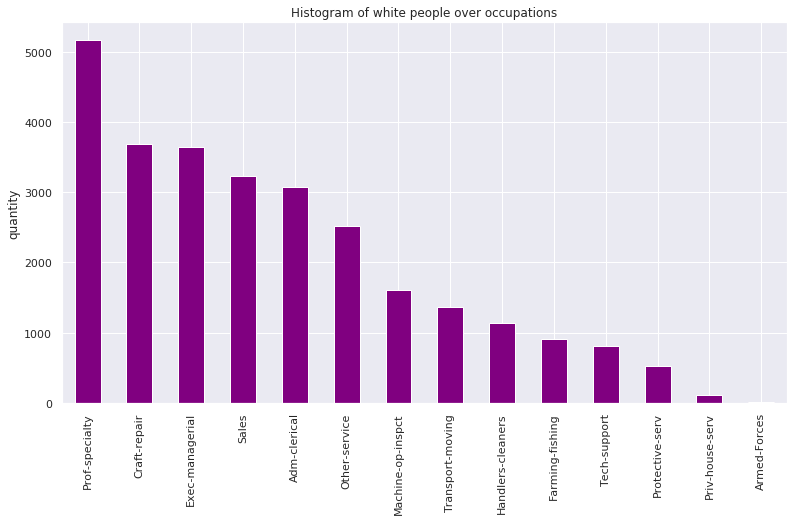

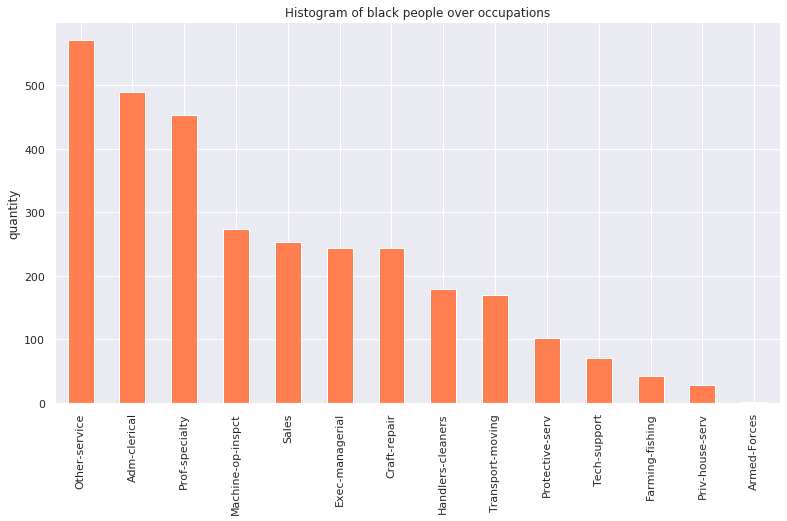

In [33]:
plt.figure(figsize=(13, 7))
white['occupation'].value_counts().plot(kind = 'bar', color = 'purple')
plt.ylabel('quantity')
plt.title('Histogram of white people over occupations')

plt.figure(figsize=(13, 7))
black['occupation'].value_counts().plot(kind = 'bar', color = 'coral')
plt.ylabel('quantity')
plt.title('Histogram of black people over occupations')

Novamente vemos que há uma grande diferença entre as ocupações para cada etnia. Além disso podemos fazer uma comparação sobre a educação.

Text(0.5, 1.0, 'Boxplot of education num over race')

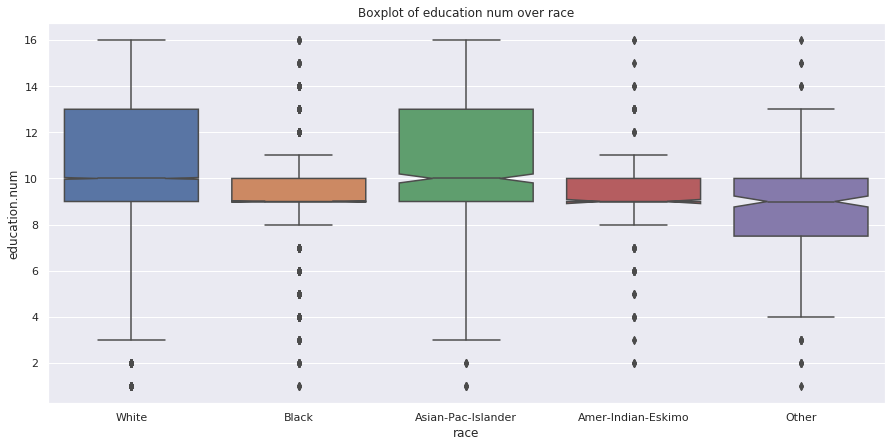

In [34]:
var1 = 'race'
var2 = 'education.num'

data = pd.concat([df_train[var2], df_train[var1]], axis=1)

f, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(x=var1, y=var2, data=data, notch = True)
plt.title('Boxplot of education num over race')

Vemos novamente, brancos e Asian-Pac-Islander, com uma educação em média superior às demais etnias.

Agora, analisaremos os salários das ocupações, para tirarmos mais conclusões.

In [35]:
over_50k = df_train[df_train['income'] == '>50K']
under_50k = df_train[df_train['income'] == '<=50K']

Text(0.5, 1.0, 'Histogram of income under 50K over occupations')

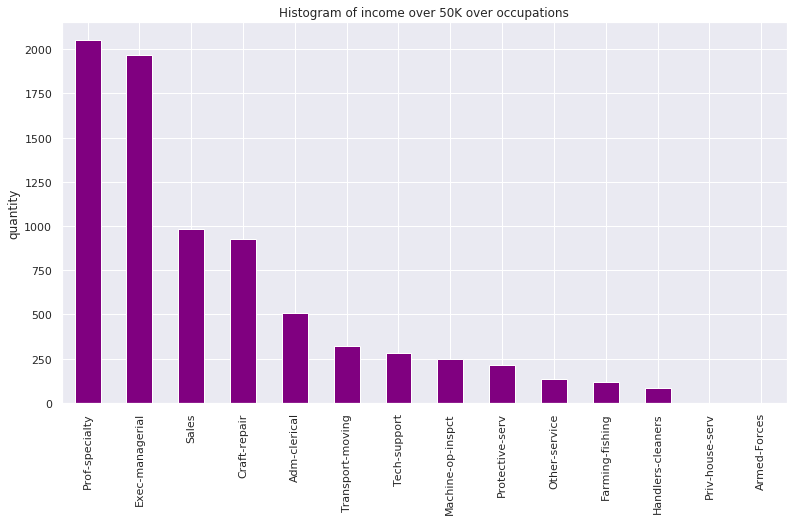

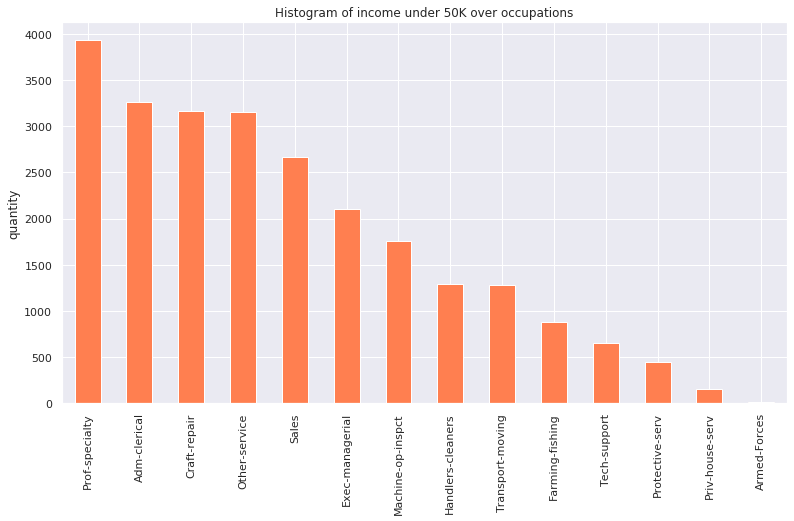

In [36]:
plt.figure(figsize=(13, 7))
over_50k['occupation'].value_counts().plot(kind = 'bar', color = 'purple')
plt.ylabel('quantity')
plt.title('Histogram of income over 50K over occupations')

plt.figure(figsize=(13, 7))
under_50k['occupation'].value_counts().plot(kind = 'bar', color = 'coral')
plt.ylabel('quantity')
plt.title('Histogram of income under 50K over occupations')

Observamos que aqueles que recebem acima de 50.000 em maioria são *Exec-managerial*, seguido por *Prof-specialty*, que são ocupações ocupadas em maioria por homens brancos. Já aqueles que recebem menos de 50.000 ocupam em maioria *Adm-clerical*, *Craft-repair*, *Other-service* e *Sales*, que são áreas que empregam maioria mulheres e negros.

Uma análise também interessante é sobre as idades.

Text(0.5, 1.0, 'Boxplot of age over hours per week')

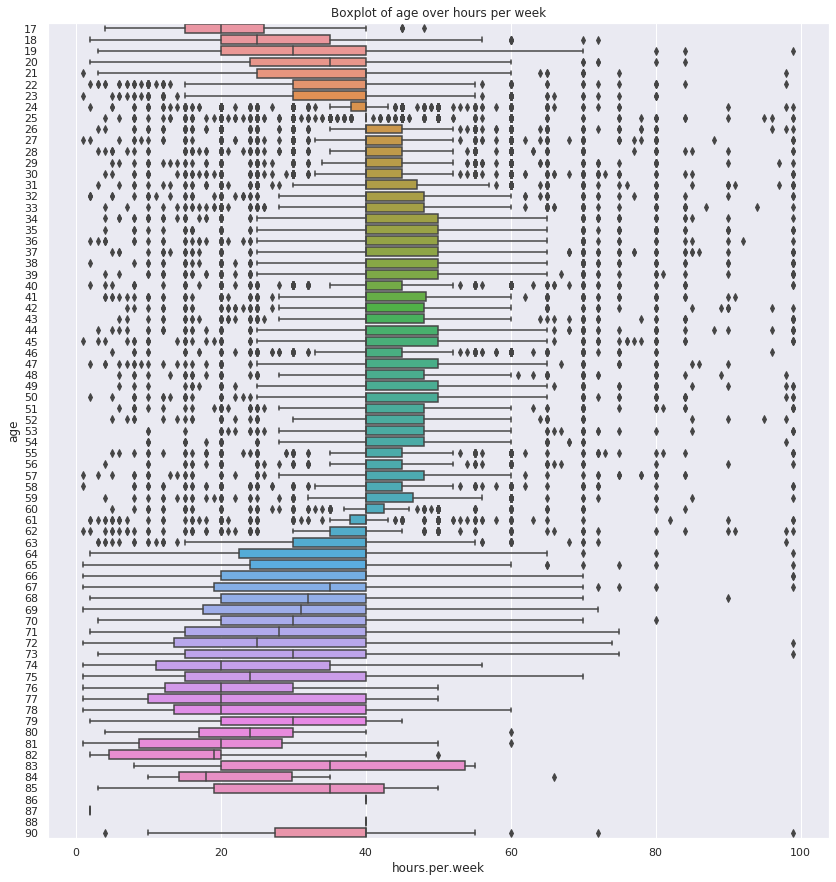

In [37]:
var2 = 'age'
var1 = 'hours.per.week'

data = pd.concat([df_train[var2], df_train[var1]], axis=1)

f, ax = plt.subplots(figsize=(14, 15))

sns.boxplot(x=var1, y=var2, data=data, orient = 'h')
plt.title('Boxplot of age over hours per week')

Aqui vemos que pessoas muito jovens trabalham em média menos de 40 horas por semana, provavelmente pois devem trabalhar meio período. Assim como pessoas mais idosas, em média trabalham também menos de 40 horas por dia.

Uma outra avaliação é sobre a quantidade de tempo de trabalho por semana com relação ao nível de educação das pessoas.

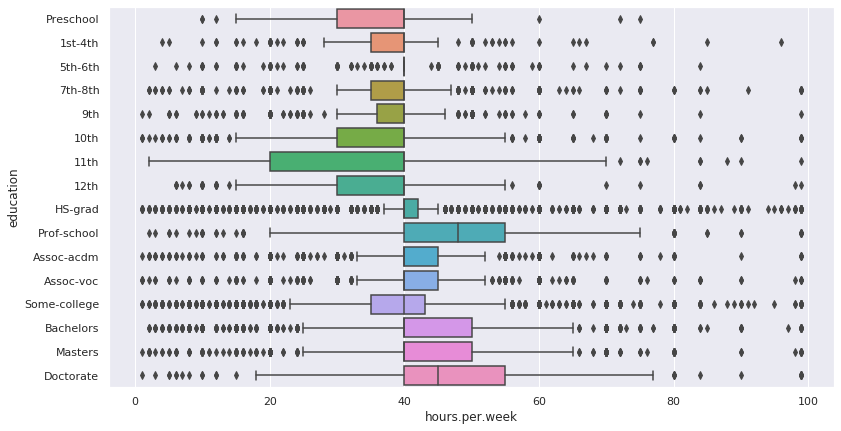

In [38]:
var2 = 'education'
var1 = 'hours.per.week'

data = pd.concat([df_train[var2], df_train[var1]], axis=1)

f, ax = plt.subplots(figsize=(13, 7))
#ax.set_ylim(0,10000)

order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
         '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc',
         'Some-college', 'Bachelors', 'Masters', 'Doctorate']
sns.boxplot(x=var1, y=var2, data=data, order = order)

Vemos que as pessoas com os maiores níveis de educação, normalmente trabalham mais de 40 horas por dia, como aqueles que possuem título de doutorado, mestrado e bacharel; como também os que concluiram uma escola profissionalizante.

# 3. Análise e preprocessamento dos atributos

Nessa seção usaremos bibliotecas como *skitlearn* para fazermos alguns preprocessamento dos dados, como também algumas análises de correlação entre os atributos para otimizarmos nosso aprendizado de máquina no futuro. 

### 3.1 Tratamento dos atributos

Agora, farei um tratamento sobre alguns dos atributos qualitativos e quantitativos de forma a numerar aqueles ordenáveis por exemplo.

#### 3.1.1 Alguns tratamentos de dados

referência: https://www.rdocumentation.org/packages/arules/versions/1.6-3/topics/Adult

*education*

- qualitativo ordenado
    - Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate
    
*workclass*

- booleano
    - isPrivate
    
*age*
 *   
- quantitativo ordenado
     - Young (0-25) < Middle-aged (26-45) < Senior (46-65) < Old (66+)
     
*hours.per.week*

- quantitativo ordenado
    - Part-time (0-25) < Full-time (25-40) < Over-time (40-60) < Too-much (60+).

*capital.gain* e *capital.loss*

- quantitativo ordenado
    - None (0) < Low (0 - mediana dos valores maiores que zero) and High (> mediana dos valores maiores que zero).

In [39]:
df_train['income'].value_counts()

<=50K    24719
>50K      7841
Name: income, dtype: int64

In [40]:
base = df_train

Agora vou dividir os atributos quantitativos e qualitativos:

In [41]:
base.columns

Index(['Id', 'age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [42]:
quatitative_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
qualitative_columns = ['Id', 'education', 'marital.status', 'occupation', 'relationship', 'race',
                       'sex', 'native.country', 'income']

#### 3.1.2 Funções

Algumas declarações de funções para o tratamento dos dados:

In [43]:
def isprivate(value):
    if value == 'Private':
        return 1
    return 0

def catg(value, categories, ordenation = None):
    if ordenation is not None:
        ordenation = np.arange(0, len(categories))
    for pos in ordenation:
        if value == categories[pos]:
            return pos
    return -1

def equals(value, x):
    for v in x:
        if v == value:
            return 1
    return 0

#### 3.1.3 *workclass*

In [44]:
base['workclass'].unique()

array(['Private', 'Local-gov', 'Self-emp-inc', 'State-gov',
       'Self-emp-not-inc', 'Federal-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [45]:
# privado: 1 se trabalha para o privado, 0 caso contrario
private = pd.DataFrame({'private': base['workclass'].apply(isprivate)})

#### 3.1.4 *native.country*

In [46]:
df_train['native.country'].value_counts()

United-States                 29752
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

In [47]:
# usa: 1 se é sul_global, 0 caso contrário
countries = ['Mexico', 'Philippines', 'Puerto-Rico', 'El-Salvador', 'India', 'Cuba', 'Jamaica',
             'South', 'China', 'Dominican-Republic', 'Vietnam', 'Guatemala', 'Columbia', 'Taiwan',
             'Haiti', 'Iran', 'Nicaragua', 'Peru', 'Ecuador', 'Trinadad&Tobago', 'Cambodia',
             'Laos', 'Thailand', 'Yugoslavia', 'Outlying-US(Guam-USVI-etc)', 'Honduras']
sul_global = pd.DataFrame({'sul.global': base['native.country'].apply(equals, args = [countries])})

#### 3.1.5 *education*

Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate

In [48]:
base['education'].unique()

array(['Some-college', '10th', 'HS-grad', 'Bachelors', 'Assoc-acdm',
       '5th-6th', 'Masters', '12th', 'Prof-school', 'Doctorate', '9th',
       '1st-4th', '7th-8th', 'Assoc-voc', '11th', 'Preschool'],
      dtype=object)

In [49]:
edu_order = [15, 11, 5, 12, 10, 1, 14, 7, 2, 8, 4, 13, 0, 3, 6, 9]
args = [base['education'].unique(), edu_order]
education_classes = pd.DataFrame({'education.classes': base['education'].apply(catg, args = args)})

#### 3.1.6 *hours.per.week*

In [50]:
aux = pd.cut(base['hours.per.week'], bins = [-1, 25, 40, 60, 200], labels = [0, 1, 2, 3])
hours_per_week_clusters = pd.DataFrame({'hours.per.week.clusters': aux})
hours_per_week_clusters = hours_per_week_clusters.astype(np.int)

#### 3.1.7 *capital.gain* e *capital.loss*

In [51]:
median = np.median(base[base['capital.gain'] > 0]['capital.gain'])
aux = pd.cut(base['capital.gain'],
             bins = [-1, 0, median, base['capital.gain'].max()+1],
             labels = [0, 1, 2])
capital_gain_clusters = pd.DataFrame({'capital.gain.clusters': aux})
capital_gain_clusters = capital_gain_clusters.astype(np.int)

median = np.median(base[base['capital.loss'] > 0]['capital.loss'])
aux = pd.cut(base['capital.loss'],
             bins = [-1, 0, median, base['capital.loss'].max()+1],
             labels = [0, 1, 2])
capital_loss_clusters = pd.DataFrame({'capital.loss.clusters': aux})
capital_loss_clusters = capital_loss_clusters.astype(np.int)

In [52]:
new_data = pd.concat([sul_global, private, education_classes, 
                      hours_per_week_clusters, capital_gain_clusters, 
                      capital_loss_clusters], axis = 1)

Por fim, construimos essa pequena tabela de dados que podem vir a ser uteis.

In [53]:
new_data.head()

,sul.global,private,education.classes,hours.per.week.clusters,capital.gain.clusters,capital.loss.clusters
0,0,1,0,2,0,0
1,0,0,1,1,0,0
2,0,1,0,2,0,0
3,0,1,0,1,0,0
4,0,0,2,2,1,0


In [54]:
aux = base['income'].apply(equals, args = [['>50K']])

aux = pd.concat([new_data, pd.DataFrame({'income': aux})], axis = 1)

new = aux.astype(np.int)
aux.head()

,sul.global,private,education.classes,hours.per.week.clusters,capital.gain.clusters,capital.loss.clusters,income
0,0,1,0,2,0,0,0
1,0,0,1,1,0,0,0
2,0,1,0,2,0,0,0
3,0,1,0,1,0,0,0
4,0,0,2,2,1,0,1


A seguir, uma simples visualização com uma matriz de correlação para termos uma ideia das contribuições sobre *income*.

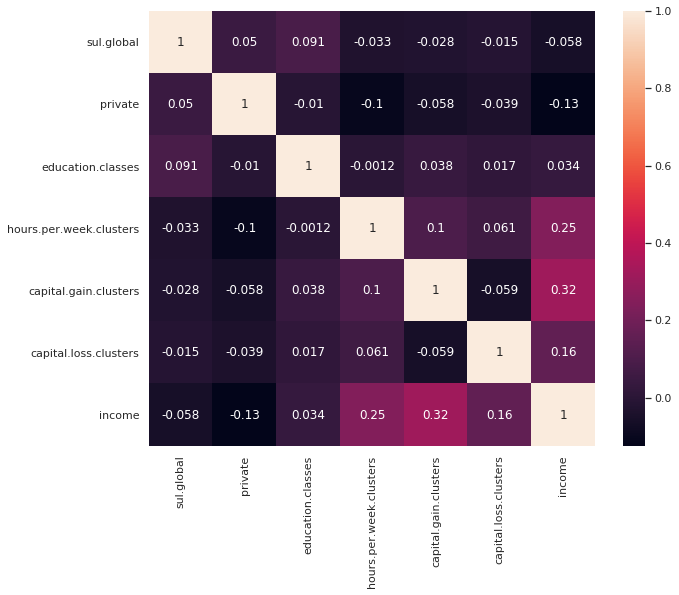

In [55]:
corr_mat = aux.corr()
corr_mat
sns.set()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True)

### 3.2 Transformações de outros dados e ajuste da tabela

Para dar início à análise dos atributos, tornarei numéricas os atributos classificatórios, para podermos usá-los de forma mais eficiente.


*Obs: antes eu removo a coluna 'Id' pois é totalmente aleatória.

In [56]:
base.columns

Index(['Id', 'age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [57]:
from sklearn.preprocessing import LabelEncoder

base = base.drop(['Id', 'education', 'capital.loss', 'capital.gain'], axis = 1)
base.columns

Index(['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'hours.per.week',
       'native.country', 'income'],
      dtype='object')

Variáveis classificatórias:
1. workclass
2. marital.status
3. occupation
4. relationship
5. race
6. sex
7. native.country
8. income

Agora, utilizo o LabelEncoder para transformar as variáveis classificatórias em números.

In [58]:
base.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income
0,34,Private,204991,10,Divorced,Exec-managerial,Own-child,White,Male,44,United-States,<=50K
1,58,Local-gov,310085,6,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K
2,25,Private,146117,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,42,United-States,<=50K
3,24,Private,138938,10,Divorced,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K
4,57,Self-emp-inc,258883,9,Married-civ-spouse,Transport-moving,Husband,White,Male,60,Hungary,>50K


In [59]:
var = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

label_encoder_y = LabelEncoder()
base['income'] = label_encoder_y.fit_transform(base['income'])

label_encoder_x = LabelEncoder()
for name in var:
    base[name] = label_encoder_x.fit_transform(base[name])

### 3.2 Junção da base com os valores construídos e seleção de alguns atributos por intuição

In [60]:
base = pd.concat([new_data, base], axis = 1)
base = base.drop(['marital.status',  'relationship', 'fnlwgt', 'hours.per.week'], axis = 1)

### 3.2 Matriz de correlação

Agora, farei uma análise sobre a correlação entre os atributos, para isso utilizarei da matriz de correlação do próprio **DataFrame** associado ao *seaborn*.

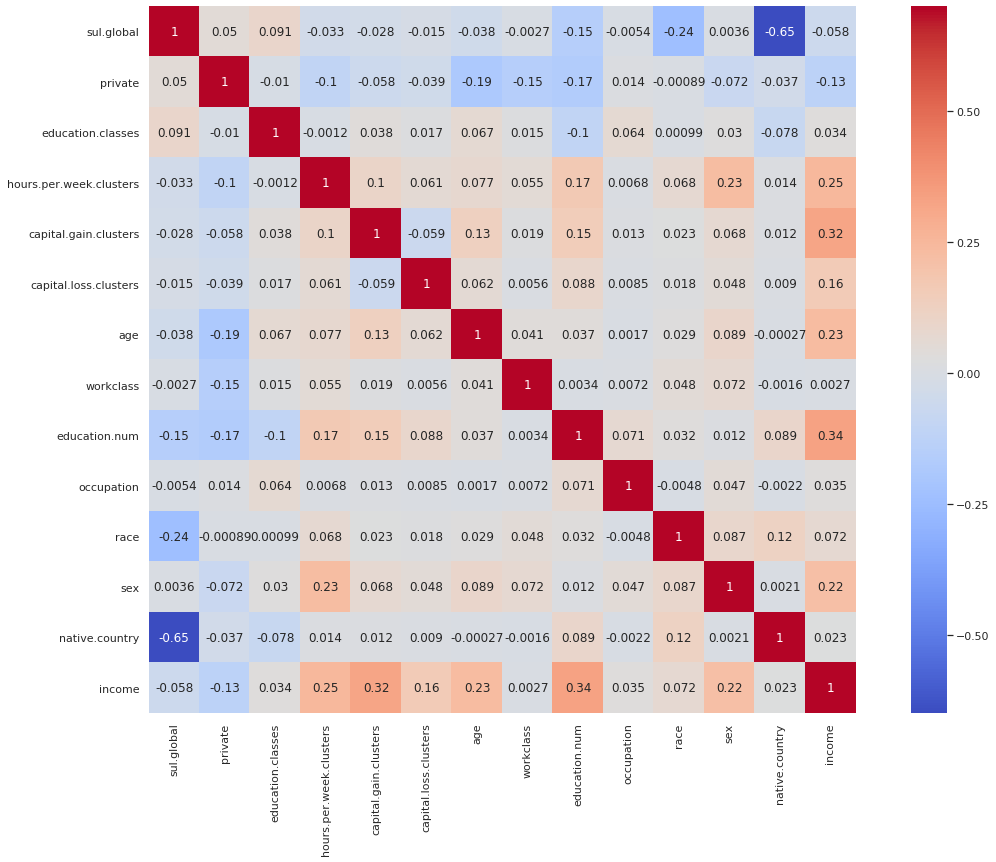

In [61]:
aux = base.astype(np.int)

corr_mat = aux.corr()
f, ax = plt.subplots(figsize=(20, 13))
sns.heatmap(corr_mat, vmax=.7, square=True, cmap="coolwarm", annot = True)

### 3.3 Remoção de atributos pouco relevantes

Utilizo a matriz de correlação acima, para visualisar e reduzir a dimenção do problema excluindo atributos pouco relevantes.

In [62]:
unselected_columns = []
unselected_columns.append('workclass')
unselected_columns.append('native.country')
unselected_columns.append('occupation')
unselected_columns.append('education.classes')
unselected_columns.append('race')
unselected_columns.append('sul.global')


base = base.drop(unselected_columns, axis = 1)

In [63]:
aux = base.astype(np.int)

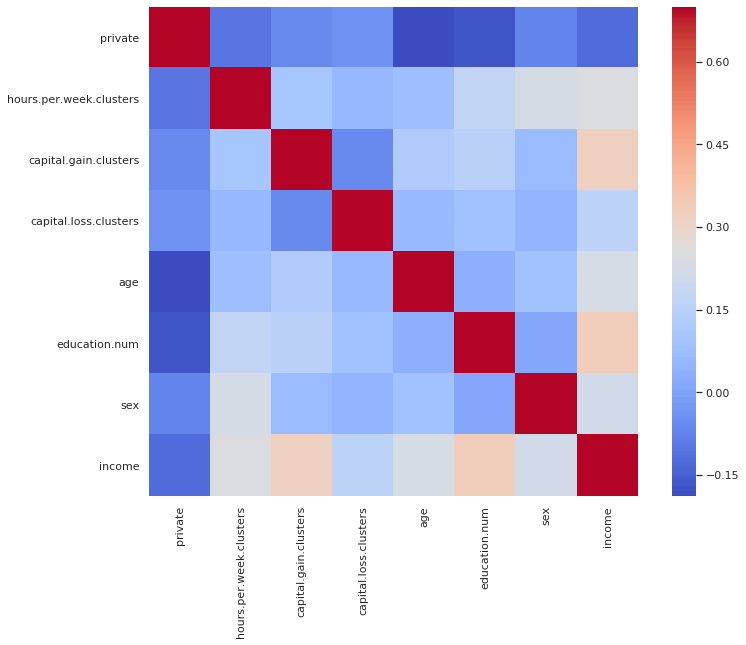

In [64]:
corr_mat = aux.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.7, square=True, cmap="coolwarm")

In [65]:
base.head()

,private,hours.per.week.clusters,capital.gain.clusters,capital.loss.clusters,age,education.num,sex,income
0,1,2,0,0,34,10,1,0
1,0,1,0,0,58,6,1,0
2,1,2,0,0,25,10,1,0
3,1,1,0,0,24,10,0,0
4,0,2,1,0,57,9,1,1


# 4. Agrupamento por K-NN

Nessa última etapa, utilizarei a biblioteca *sklearn* para utilização do método de aprendizado **k-NN**. Nesse processo, farei o uso da **validação cruzada** para avaliar o desempenho do modelo.

### 4.1 Escalonamento dos dados

Primeiro farei um tratamento sobre os dados, de forma a escaloná-los utilizando *StandardScaler*.

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
base.shape

(32560, 8)

In [68]:
X = base.drop(['income'], axis = 1)
y = base['income']

In [69]:
scaler_x = StandardScaler()

X = scaler_x.fit_transform(X)

### 4.3 Definição do hiperparâmetro k do k-NN

Primeiro, avaliaremos o comportamento do aprenzidado para k = 1, ..., 29 para que possamos identificar o melhor valor de k para utilizarmos para prever os valores da base de teste a ser importada. Essa avaliação, será feita com a utilização da validação cruzada com 5 *folds*, e assim será possível determinar o melhor hiperparâmetro k que se aplicará ao nosso problema.

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

scores_mean = []
scores_std = []

k_lim_inf = 1
k_lim_sup = 30

folds = 5

k_max = None
max_acc = 0

i = 0
print('Finding best k...')
for k in range(k_lim_inf, k_lim_sup):
    
    KNNclf = KNeighborsClassifier(n_neighbors=k)
    
    score = cross_val_score(KNNclf, X, y, cv = folds)
    
    scores_mean.append(score.mean())
    scores_std.append(score.std())
    
    if scores_mean[i] > max_acc:
        k_max = k
        max_acc = scores_mean[i]
    i += 1
    if not (k%3):
        print('   K = {0} | Best CV acc = {1:2.2f}% (best k = {2})'.format(k, max_acc*100, k_max))
print('\nBest k: {}'.format(k_max))

Finding best k...
   K = 3 | Best CV acc = 80.16% (best k = 2)
   K = 6 | Best CV acc = 81.52% (best k = 6)
   K = 9 | Best CV acc = 81.84% (best k = 8)
   K = 12 | Best CV acc = 82.19% (best k = 12)
   K = 15 | Best CV acc = 82.27% (best k = 14)
   K = 18 | Best CV acc = 82.52% (best k = 18)
   K = 21 | Best CV acc = 82.55% (best k = 19)
   K = 24 | Best CV acc = 82.55% (best k = 19)
   K = 27 | Best CV acc = 82.55% (best k = 19)

Best k: 19


[0, 30, 0.7603115490479393, 0.8317685106460546]

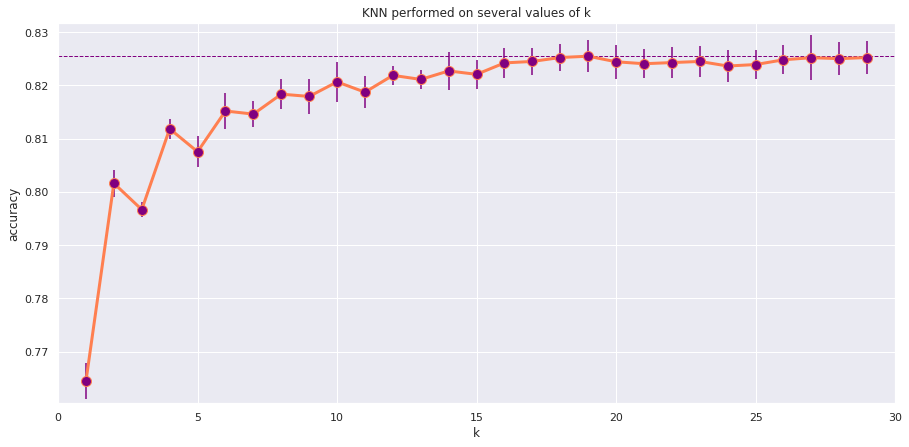

In [71]:
plt.figure(figsize=(15, 7))
plt.errorbar(np.arange(k_lim_inf, k_lim_sup), scores_mean, scores_std,
             marker = 'o', markerfacecolor = 'purple' , linewidth = 3,
             markersize = 10, color = 'coral', ecolor = 'purple', elinewidth = 1.5)


yg = []
x = np.arange(0, k_lim_sup+1)
for i in range(len(x)):
    yg.append(max_acc)
plt.plot(x, yg, '--', color = 'purple', linewidth = 1)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('KNN performed on several values of k')
plt.axis([0, k_lim_sup, min(scores_mean) - max(scores_std), max(scores_mean) + 1.5*max(scores_std)])

Acima vemos o gráfico dos erros médios sobre a validação cruzada para diferentes valores de k, em que foi possível determinar o melhor k que satisfaz nosso problema.

### 4.4 Treinamento do k-NN

Agora, faremos o treinamento do k-NN utilizando nossa base de treino, em seguida inferimos sobre nossa acurácia da base de testes.

In [72]:
k = k_max

KNNclf = KNeighborsClassifier(n_neighbors=k, p = 1)
KNNclf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=1,
                     weights='uniform')

# 5. Predição dos valores sem classe

Nessa última etapa, utilizaremos o nosso classificador treinado para predizer sobre as classes do banco de dados teste que não possui valor de classe atribuído aos indivíduos.

In [81]:
df_test = pd.read_csv('test_data.csv', na_values='?')
df_test.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


### 5.1 Adição das colunas extra

In [87]:
# privado: 1 se trabalha para o privado, 0 caso contrario
private = pd.DataFrame({'private': df_test['workclass'].apply(isprivate)})

# hours.per.week.cluster
aux = pd.cut(df_test['hours.per.week'], bins = [-1, 25, 40, 60, 200], labels = [0, 1, 2, 3])
hours_per_week_clusters = pd.DataFrame({'hours.per.week.clusters': aux})
hours_per_week_clusters = hours_per_week_clusters.astype(np.int)

# capital.gain.cluster
median = np.median(df_test[df_test['capital.gain'] > 0]['capital.gain'])
aux = pd.cut(df_test['capital.gain'],
             bins = [-1, 0, median, df_test['capital.gain'].max()+1],
             labels = [0, 1, 2])
capital_gain_clusters = pd.DataFrame({'capital.gain.clusters': aux})
capital_gain_clusters = capital_gain_clusters.astype(np.int)

# capital.loss.cluster
median = np.median(df_test[df_test['capital.loss'] > 0]['capital.loss'])
aux = pd.cut(df_test['capital.loss'],
             bins = [-1, 0, median, df_test['capital.loss'].max()+1],
             labels = [0, 1, 2])
capital_loss_clusters = pd.DataFrame({'capital.loss.clusters': aux})
capital_loss_clusters = capital_loss_clusters.astype(np.int)

new_data = pd.concat([private, hours_per_week_clusters,
                      capital_gain_clusters, capital_loss_clusters], axis = 1)

In [88]:
features = ['age', 'education.num', 'sex']

base_test = pd.concat([new_data, df_test[features]], axis = 1)

Verificando dados faltantes

In [89]:
total = base_test.isnull().sum().sort_values(ascending = False)
percent = ((base_test.isnull().sum()/base_test.isnull().count())*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', '%'])
missing_data.head()

,Total,%
sex,0,0.0
education.num,0,0.0
age,0,0.0
capital.loss.clusters,0,0.0
capital.gain.clusters,0,0.0


In [90]:
base_test.head()

,private,hours.per.week.clusters,capital.gain.clusters,capital.loss.clusters,age,education.num,sex
0,1,2,0,0,25,13,Male
1,0,2,0,0,64,13,Male
2,1,1,0,0,31,14,Female
3,1,1,0,0,45,9,Male
4,0,2,0,0,64,13,Male


Primeiro ajustamos os dados para eles estarem de acordo com o formado do treino.

In [91]:
base_test['sex'] = base_test['sex'].apply(equals, args = [['Male']])
X_prev = scaler_x.transform(base_test)

Enfim, predizemos as classes:

In [92]:
temp = KNNclf.predict(X_prev)

temp = label_encoder_y.inverse_transform(temp)
temp = {'income': temp}
predicts = pd.DataFrame(temp)

predictions = pd.concat([df_test['Id'], predicts], axis = 1)

In [93]:
predictions.head()

,Id,income
0,0,<=50K
1,1,<=50K
2,2,<=50K
3,3,<=50K
4,4,<=50K


Por fim, escrevo os resultados em **submission.csv**

In [94]:
predictions.to_csv("submission.csv",index=False)